In [1]:
import torch
from torch import nn

torch.__version__

'2.0.1+cu118'

In [2]:
# Setting up device-agonistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")

Device in use: cuda


In [3]:
# Downloading Pizza, Steak and Sushi Data

import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
import os
def walkThroughDir(dir_path):
  """
  This function walks through dir_path returning its contents
  """

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} image files in '{dirpath}'.")

In [5]:
walkThroughDir(image_path)

There are 2 directories and 0 image files in 'data/pizza_steak_sushi'.
There are 3 directories and 0 image files in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 image files in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 image files in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 image files in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 image files in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 image files in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 image files in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 image files in 'data/pizza_steak_sushi/train/steak'.


In [6]:
# Setup training and testing paths

trainDir = image_path/"train"
testDir = image_path/"test"

trainDir, testDir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random Image Path: data/pizza_steak_sushi/test/steak/27415.jpg
Image Class: steak
Image Dimensions (width X height): 512x384


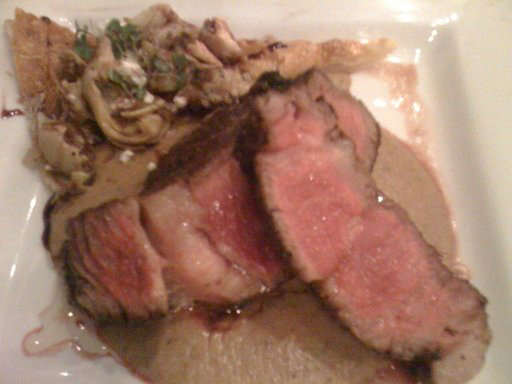

In [7]:
import random
from PIL import Image

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Getting all image paths
imagePathList = list(image_path.glob("*/*/*.jpg"))

# Getting a random image path
randomImagePath = random.choice(imagePathList)
imageClass = randomImagePath.parent.stem

img = Image.open(randomImagePath)

print(f"Random Image Path: {randomImagePath}")
print(f"Image Class: {imageClass}")
print(f"Image Dimensions (width X height): {img.width}x{img.height}")
img

In [8]:
# Converting image data into tensors

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Image transformation
dataTransform = transforms.Compose([
    transforms.Resize(size=(64, 64)),  # Image resize to 64x64
    transforms.RandomHorizontalFlip(p=0.5),  # Probability of horizontal image flip = 50%
    transforms.ToTensor()  # Convert to tensor
])

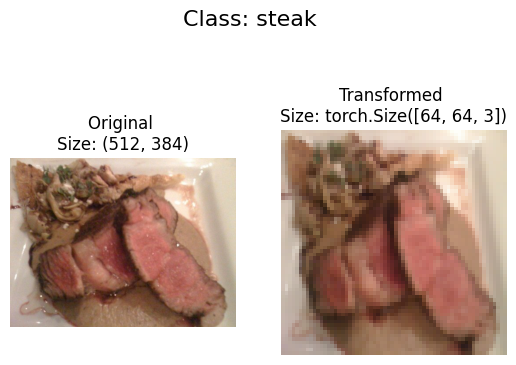

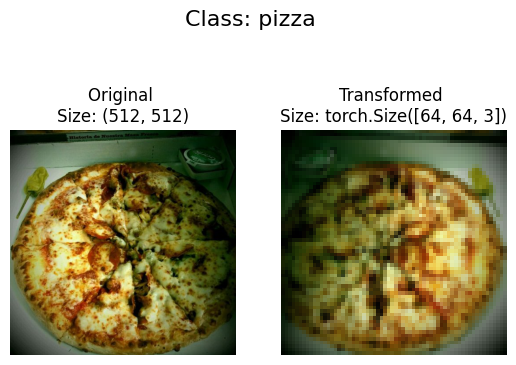

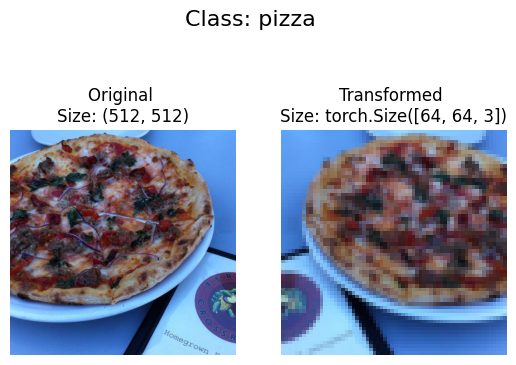

In [9]:
import matplotlib.pyplot as plt

def plotTransformedImages(image_paths, transform, n=3, seed=RANDOM_SEED):
  """
  This function plots a series of random images from image_paths.

  This will open 'n' image paths from image_paths, transforms them and
  plots them side by side
  """

  random.seed(seed)
  randomImagePaths = random.sample(image_paths, k=n)
  for image_path in randomImagePaths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      transformedImage = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformedImage)
      ax[1].set_title(f"Transformed \nSize: {transformedImage.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plotTransformedImages(imagePathList, transform=dataTransform, n=3)

In [10]:
from torchvision import datasets
trainData = datasets.ImageFolder(root=trainDir,
                                 transform=dataTransform,
                                 target_transform=None)

testData = datasets.ImageFolder(root=testDir,
                                transform=dataTransform)

print(f"Train Data:\n{trainData}\nTest Data:\n{testData}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [11]:
classNames = trainData.classes
classDict = trainData.class_to_idx

print(f"Class Names: {classNames}\nClass Dictionary: {classDict}")

Class Names: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}


In [12]:
len(trainData), len(testData)

(225, 75)

In [13]:
img, label = trainData[0][0], trainData[0][1]
print(f"Image Tensor:\n{img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label Datatype: {type(label)}")

Image Tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original Shape: torch.Size([3, 64, 64]) -> [Colour Channels, Height, Width]
Image Permute Shape: torch.Size([64, 64, 3]) -> [Height, Width, Colour Channels]


Text(0.5, 1.0, 'pizza')

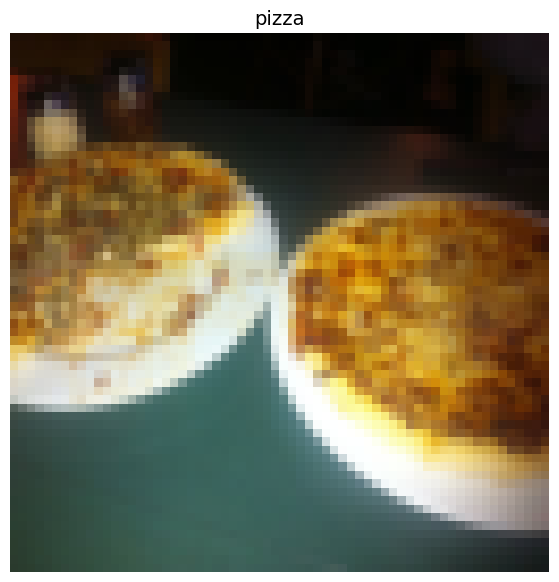

In [14]:
# Plotting an image

imgPermute = img.permute(1, 2, 0)
print(f"Original Shape: {img.shape} -> [Colour Channels, Height, Width]")
print(f"Image Permute Shape: {imgPermute.shape} -> [Height, Width, Colour Channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(classNames[label], fontsize=14)